# Training notebook

## Import libraries

Make sure to import model class, dataset class and associated preprocessing operations.

In [1]:
# Standard libraries
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import datetime
from tensorboardX import SummaryWriter
import os
import zipfile
import time
import seaborn as sns
import pandas as pd

# Custom functions/classes
from load_data import DataProcesser
from train_utils import accuracy, AverageMeter
from models import ConvNetCam, ConvNetCamBi
from class_dataset import myDataset, ToTensor, Subtract, RandomShift, RandomNoise, RandomCrop, FixedCrop

# For reproducibility
myseed = 7
torch.manual_seed(myseed)
torch.cuda.manual_seed(myseed)
np.random.seed(myseed)

## Hyperparameters for training

Hyperparameters for training:
- nepochs: int, number of training epochs.
- batch_size: int.
- lr: float, initial learning rate.
- L2_reg: float, L2 regularization factor. This helps to prevent overfitting. In general try to always have a mild regularization, say 1e-3. Increase if you face overfitting issues.

Hyperparameters to setup the model dimensions:
- length: int, length of a trajectory. This is the length as the model will expect it. Setting it to smaller value than the actual length can be used for preprocessing/data jittering.
- nclass: int, number of output classes.
- nfeatures: int, size of the input representation before output layer. This also corresponds to the number of filters in the last convolution layer.
- selected_classes: list, select only some classes from input dataset. Leave empty to use all classes.

In [2]:
nepochs = 2000
batch_size = 128
lr = 1e-4
L2_reg = 1e-1

length = 28
nclass = 12
nfeatures = 5
selected_classes = []

## Load and process data, Data augmentation

Define which data to load and whether/how to preprocess the batch. 
- data_file: str, path to a .zip that can be loaded as a DataProcesser. The archive must contain 3 files: one for the
 data, one for the split train/validation, one with the classes informations. See DataProcesser.read_archive().
- meas_var: list of str or None, names of the measurement variables. In DataProcesser convention, this is the prefix in a
 column name that contains a measurement (time being the suffix). Pay attention to the order since this is how the dimensions of a sample of data will be ordered (i.e. 1st in the list will form 1st row of measurements in the sample, 2nd is the 2nd, etc...) If None, DataProcesser will extract automatically the measurement names and use the order of appearance in the column names.
- start_time/end_time: int or None, use to subset data to a specific time range. If None, DataProcesser will extract automatically the range of time in the dataset columns. Useful to completely exclude some acquisition times where irrelevant measurements are acquired. 

In [3]:
# data_file = '/home/marc/Dropbox/Work/TSclass_GF/data/ErkAkt_6GF_len240_repl2_trim100.zip'
# data_file = '/home/marc/Dropbox/CNN_paper_MarcAntoine/forPaper/data_analysis/synthetic_len750_univariate_classAB.zip'
# data_file = '/home/marc/Dropbox/CNN_paper_MarcAntoine/forPaper/data_analysis/synthetic_len750.zip'
#data_file = '/home/marc/Dropbox/CNN_paper_MarcAntoine/forPaper/data_analysis/drosophila.zip'
data_file='/home/marc/Desktop/WW_Archive.zip'
meas_var = None
start_time = 10
end_time = None

In [4]:
data = DataProcesser(data_file, datatable=False)


In [5]:
# Read default 
meas_var = data.detect_groups_times()['groups'] if meas_var is None else meas_var
start_time = data.detect_groups_times()['times'][0] if start_time is None else start_time
end_time = data.detect_groups_times()['times'][1] if end_time is None else end_time
data.subset(sel_groups=meas_var, start_time=start_time, end_time=end_time)
if selected_classes:
    data.dataset = data.dataset[data.dataset[data.col_class].isin(selected_classes)]
data.get_stats()
# data.process(method='center_train', independent_groups=True)
data.split_sets()

subtract_numbers = [data.stats['mu'][meas]['train'] for meas in meas_var]
ls_transforms = transforms.Compose([
    RandomCrop(output_size=length, ignore_na_tails=True),
    #transforms.RandomApply([RandomNoise(mu=0, sigma=0.02)]),
    Subtract(subtract_numbers),
    ToTensor()])

data_train = myDataset(dataset=data.train_set, transform=ls_transforms)
data_test = myDataset(dataset=data.validation_set, transform=ls_transforms)

print('Channels order: {} \nTime range: ({}, {}) \nClasses: {}'.format(meas_var, start_time, end_time, list(data.dataset[data.col_class].unique())))

Channels order: ['ERK'] 
Time range: (10, 40) 
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


/home/marc/Dropbox/Work/TSclass_GF/load_data.py:461: UserWarning: Data were not processed.
  warnings.warn('Data were not processed.')


Plot some trajectories to check that the data loading and processing is properly done.

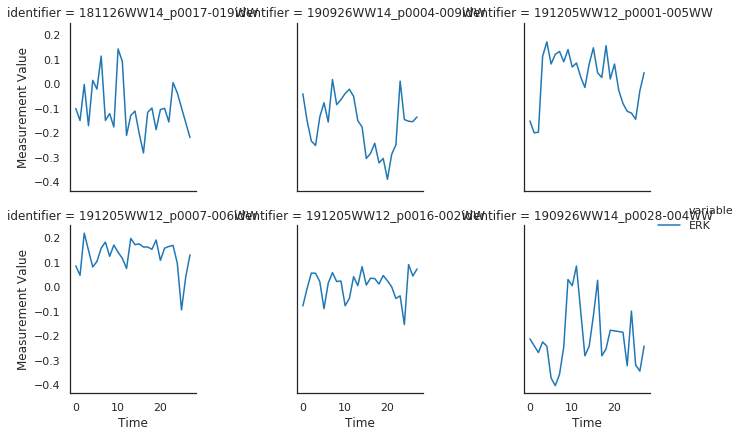

In [6]:
n_smpl = 6
indx_smpl = np.random.randint(0, len(data_train), n_smpl)

col_ids = []
col_lab = []
col_mes = []
# Long format for seaborn grid, for loop to avoid multiple indexing
# This would triggers preprocessing multiple times and add randomness
for i in indx_smpl:
    smpl = data_train[i]
    col_ids.append(smpl['identifier'])
    col_lab.append(smpl['label'].item())
    col_mes.append(smpl['series'].numpy().transpose())
col_ids = pd.Series(np.hstack(np.repeat(col_ids, length)))
col_lab = pd.Series(np.hstack(np.repeat(col_lab, length)))
col_mes = pd.DataFrame(np.vstack(col_mes), columns=meas_var)
col_tim = pd.Series(np.tile(np.arange(0, length), n_smpl))

df_smpl = pd.concat([col_ids, col_lab, col_tim, col_mes], axis=1)
df_smpl.rename(columns={0: 'identifier', 1: 'label', 2:'time'}, inplace=True)
df_smpl = df_smpl.melt(id_vars=['identifier', 'label', 'time'], value_vars=meas_var)

sns.set_style('white')
sns.set_context('notebook')
grid = sns.FacetGrid(data=df_smpl, col='identifier', col_wrap=3, sharex=True)
grid.map_dataframe(sns.lineplot, x='time', y='value', hue='variable')
grid.set(xlabel='Time', ylabel='Measurement Value')
grid.add_legend()

## Resume training or new model

Set to None for new model, otherwise provide the path to a saved model file. 

In [7]:
load_model = None
# load_model = 'path/to/file.pytorch'

## Tensorboard logs and model save file

Unique name for model with timestamp. Can follow training online with tensorboard with these logs

In [8]:
file_logs = os.path.splitext(os.path.basename(data_file))[0]  # file name without extension
logs_str = 'logs/' + '_'.join(meas_var) + '/' + datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S') + \
           '_' + file_logs + '/'
writer = SummaryWriter(logs_str)
save_model = 'models/' + logs_str.lstrip('logs/').rstrip('/') + '.pytorch'

if not os.path.exists(file_logs):
    os.makedirs(file_logs)
if not os.path.exists('models/' + '_'.join(meas_var)):
    os.makedirs('models/' + '_'.join(meas_var))

## Setup model, loss and optimizer

The model dimensions are tuned to fit the previous parameters. 

L2 regularization is controlled by the "weight_decay" in the optimizer object.

In [9]:
model = ConvNetCam(batch_size=batch_size, nclass=nclass, length=length, nfeatures=nfeatures)
if load_model:
    model.load_state_dict(torch.load(load_model))
model.double()
cuda_available = torch.cuda.is_available()
if cuda_available:
    model = model.cuda()
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=L2_reg)
criterion = torch.nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000, 1500, 2000, 2500], gamma=0.1)

## Training loop

In [10]:
def TrainModel(model, optimizer, criterion, scheduler, train_loader, test_loader, nepochs,
               save_model=save_model, logs=True, save_pyfiles=True):
    # ------------------------------------------------------------------------------------------------------------------
    # Model, loss, optimizer
    top1 = AverageMeter()
    top2 = AverageMeter()

    # Create zip archive with all python file at execution time
    if save_pyfiles:
        lpy = [i for i in os.listdir(".") if i.endswith(".py")]
        with zipfile.ZipFile(logs_str + "AllPyFiles.zip", mode='w') as zipMe:
            for file in lpy:
                zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)
    if logs:
        print('Train logs saved at: {}'.format(logs_str))

    # ------------------------------------------------------------------------------------------------------------------
    # Get adequate size of sample for nn.Conv layers
    # Add a dummy channel dimension for conv1D layer (if multivariate, treat as a 2D plane with 1 channel)
    assert len(train_loader.dataset[0]['series'].shape) == 2
    nchannel, univar_length = train_loader.dataset[0]['series'].shape
    if nchannel == 1:
        view_size = (batch_size, 1, univar_length)
    elif nchannel >= 2:
        view_size = (batch_size, 1, nchannel, univar_length)

    # ------------------------------------------------------------------------------------------------------------------
    # Training loop
    for epoch in range(nepochs):
        model.train()
        top1.reset()
        top2.reset()

        loss_train = []
        for i_batch, sample_batch in enumerate(train_loader):
            series, label = sample_batch['series'], sample_batch['label']
            if cuda_available:
                series, label = series.cuda(), label.cuda()
            series = series.view(view_size)
            prediction = model(series)
            loss = criterion(prediction, label)
            loss_train.append(loss.cpu().detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i_batch % 25 == 0:
                print('Training epoch: [{0}/{4}][{1}/{2}]; Loss: {3}'.format(epoch + 1, i_batch + 1, len(train_loader),
                                                                             loss, nepochs))

            prec1, prec2 = accuracy(prediction, label, topk=(1, 2))
            top1.update(prec1[0], series.size(0))
            top2.update(prec2[0], series.size(0))

            if i_batch % 100 == 0:
                print('Training Accuracy Epoch: [{0}]\t'
                      'Prec@1 {top1.val.data:.3f} ({top1.avg.data:.3f})\t'
                      'Prec@2 {top2.val.data:.3f} ({top2.avg.data:.3f})'.format(
                    epoch, top1=top1, top2=top2))
            if logs:
                writer.add_scalar('Train/Loss', loss, epoch * len(train_loader) + i_batch + 1)
                writer.add_scalar('Train/Top1', top1.val, epoch * len(train_loader) + i_batch + 1)
                writer.add_scalar('Train/Top2', top2.val, epoch * len(train_loader) + i_batch + 1)
        if logs:
            writer.add_scalar('MeanEpoch/Train_Loss', np.mean(loss_train), epoch)
            writer.add_scalar('MeanEpoch/Train_Top1', top1.avg, epoch)
            writer.add_scalar('MeanEpoch/Train_Top2', top2.avg, epoch)

        # --------------------------------------------------------------------------------------------------------------
        # Evaluation loop
        model.eval()
        top1.reset()
        top2.reset()
        loss_eval = []
        for i_batch, sample_batch in enumerate(test_loader):
            series, label = sample_batch['series'], sample_batch['label']
            if cuda_available:
                series, label = series.cuda(), label.cuda()
            series = series.view(view_size)
            label = torch.autograd.Variable(label)
            
            prediction = model(series)
            loss = criterion(prediction, label)
            loss_eval.append(loss.cpu().detach().numpy())

            prec1, prec2 = accuracy(prediction, label, topk=(1, 2))
            top1.update(prec1[0], series.size(0))
            top2.update(prec2[0], series.size(0))

        # For validation loss, report only after the whole batch is processed
        if logs:
            writer.add_scalar('Val/Loss', loss, epoch * len(train_loader) + i_batch + 1)
            writer.add_scalar('Val/Top1', top1.val, epoch * len(train_loader) + i_batch + 1)
            writer.add_scalar('Val/Top2', top2.val, epoch * len(train_loader) + i_batch + 1)
            writer.add_scalar('MeanEpoch/Val_Loss', np.mean(loss_eval), epoch)
            writer.add_scalar('MeanEpoch/Val_Top1', top1.avg, epoch)
            writer.add_scalar('MeanEpoch/Val_Top2', top2.avg, epoch)


        print('===>>>\t'
              'Prec@1 ({top1.avg.data:.3f})\t'
              'Prec@2 ({top2.avg.data:.3f})'.format(top1=top1, top2=top2))

        writer.add_scalar('LearningRate', optimizer.param_groups[0]['lr'], epoch)
        #scheduler.step(np.mean(loss_eval))
        scheduler.step()
        
        
    if save_model:
        torch.save(model, save_model)
        print('Model saved at: {}'.format(save_model))
    return model


## Run the training

Can follow the training in tensorboard with:
```
tensorboard --logdir "path/to/logs"
```

In [11]:
train_loader = DataLoader(dataset=data_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          drop_last=True)
test_loader = DataLoader(dataset=data_test,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=4,
                         drop_last=True)

t0 = time.time()
mymodel = TrainModel(model, optimizer, criterion, scheduler, train_loader, test_loader, nepochs)
t1 = time.time()

print('Elapsed time: {}'.format(t1 - t0))

Train logs saved at: logs/ERK/2020-02-21-15:39:22_WW_Archive/
Training epoch: [1/2000][1/4]; Loss: 2.528763921074193
Training Accuracy Epoch: [0]	Prec@1 11.719 (11.719)	Prec@2 21.094 (21.094)
===>>>	Prec@1 (7.812)	Prec@2 (12.500)
Training epoch: [2/2000][1/4]; Loss: 2.5524611268939466
Training Accuracy Epoch: [1]	Prec@1 7.812 (7.812)	Prec@2 14.062 (14.062)
===>>>	Prec@1 (10.938)	Prec@2 (15.625)
Training epoch: [3/2000][1/4]; Loss: 2.511398568324134
Training Accuracy Epoch: [2]	Prec@1 7.812 (7.812)	Prec@2 25.000 (25.000)
===>>>	Prec@1 (10.156)	Prec@2 (15.625)
Training epoch: [4/2000][1/4]; Loss: 2.5407067264684047
Training Accuracy Epoch: [3]	Prec@1 9.375 (9.375)	Prec@2 17.969 (17.969)
===>>>	Prec@1 (5.469)	Prec@2 (17.188)
Training epoch: [5/2000][1/4]; Loss: 2.5491181765220503
Training Accuracy Epoch: [4]	Prec@1 5.469 (5.469)	Prec@2 17.969 (17.969)
===>>>	Prec@1 (7.031)	Prec@2 (14.844)
Training epoch: [6/2000][1/4]; Loss: 2.513113688362335
Training Accuracy Epoch: [5]	Prec@1 11.719 (11

===>>>	Prec@1 (10.938)	Prec@2 (21.094)
Training epoch: [49/2000][1/4]; Loss: 2.4695219627821587
Training Accuracy Epoch: [48]	Prec@1 13.281 (13.281)	Prec@2 30.469 (30.469)
===>>>	Prec@1 (6.250)	Prec@2 (17.969)
Training epoch: [50/2000][1/4]; Loss: 2.4603242760617787
Training Accuracy Epoch: [49]	Prec@1 15.625 (15.625)	Prec@2 30.469 (30.469)
===>>>	Prec@1 (8.594)	Prec@2 (22.656)
Training epoch: [51/2000][1/4]; Loss: 2.4897480403350225
Training Accuracy Epoch: [50]	Prec@1 13.281 (13.281)	Prec@2 28.125 (28.125)
===>>>	Prec@1 (10.938)	Prec@2 (21.094)
Training epoch: [52/2000][1/4]; Loss: 2.4705920779733086
Training Accuracy Epoch: [51]	Prec@1 15.625 (15.625)	Prec@2 30.469 (30.469)
===>>>	Prec@1 (9.375)	Prec@2 (20.312)
Training epoch: [53/2000][1/4]; Loss: 2.476060750780632
Training Accuracy Epoch: [52]	Prec@1 14.062 (14.062)	Prec@2 26.562 (26.562)
===>>>	Prec@1 (10.938)	Prec@2 (21.094)
Training epoch: [54/2000][1/4]; Loss: 2.492565491420977
Training Accuracy Epoch: [53]	Prec@1 12.500 (12.5

===>>>	Prec@1 (13.281)	Prec@2 (21.875)
Training epoch: [97/2000][1/4]; Loss: 2.475892570423039
Training Accuracy Epoch: [96]	Prec@1 13.281 (13.281)	Prec@2 23.438 (23.438)
===>>>	Prec@1 (14.062)	Prec@2 (24.219)
Training epoch: [98/2000][1/4]; Loss: 2.4490453628590947
Training Accuracy Epoch: [97]	Prec@1 14.062 (14.062)	Prec@2 30.469 (30.469)
===>>>	Prec@1 (9.375)	Prec@2 (17.969)
Training epoch: [99/2000][1/4]; Loss: 2.4803631411307103
Training Accuracy Epoch: [98]	Prec@1 14.062 (14.062)	Prec@2 24.219 (24.219)
===>>>	Prec@1 (12.500)	Prec@2 (22.656)
Training epoch: [100/2000][1/4]; Loss: 2.4307456399340386
Training Accuracy Epoch: [99]	Prec@1 18.750 (18.750)	Prec@2 32.812 (32.812)
===>>>	Prec@1 (10.938)	Prec@2 (22.656)
Training epoch: [101/2000][1/4]; Loss: 2.448453038070838
Training Accuracy Epoch: [100]	Prec@1 18.750 (18.750)	Prec@2 35.156 (35.156)
===>>>	Prec@1 (14.062)	Prec@2 (23.438)
Training epoch: [102/2000][1/4]; Loss: 2.461535120815952
Training Accuracy Epoch: [101]	Prec@1 14.062

===>>>	Prec@1 (18.750)	Prec@2 (26.562)
Training epoch: [145/2000][1/4]; Loss: 2.457136116148197
Training Accuracy Epoch: [144]	Prec@1 17.188 (17.188)	Prec@2 25.781 (25.781)
===>>>	Prec@1 (17.969)	Prec@2 (25.000)
Training epoch: [146/2000][1/4]; Loss: 2.4775092292922944
Training Accuracy Epoch: [145]	Prec@1 17.969 (17.969)	Prec@2 23.438 (23.438)
===>>>	Prec@1 (17.188)	Prec@2 (27.344)
Training epoch: [147/2000][1/4]; Loss: 2.413728639674719
Training Accuracy Epoch: [146]	Prec@1 25.000 (25.000)	Prec@2 36.719 (36.719)
===>>>	Prec@1 (15.625)	Prec@2 (24.219)
Training epoch: [148/2000][1/4]; Loss: 2.417660151674093
Training Accuracy Epoch: [147]	Prec@1 21.875 (21.875)	Prec@2 35.156 (35.156)
===>>>	Prec@1 (15.625)	Prec@2 (22.656)
Training epoch: [149/2000][1/4]; Loss: 2.4546254983409126
Training Accuracy Epoch: [148]	Prec@1 16.406 (16.406)	Prec@2 28.125 (28.125)
===>>>	Prec@1 (17.188)	Prec@2 (26.562)
Training epoch: [150/2000][1/4]; Loss: 2.4773031500073293
Training Accuracy Epoch: [149]	Prec@

Training epoch: [192/2000][1/4]; Loss: 2.4261020222033727
Training Accuracy Epoch: [191]	Prec@1 17.969 (17.969)	Prec@2 29.688 (29.688)
===>>>	Prec@1 (16.406)	Prec@2 (24.219)
Training epoch: [193/2000][1/4]; Loss: 2.3971398776891766
Training Accuracy Epoch: [192]	Prec@1 22.656 (22.656)	Prec@2 31.250 (31.250)
===>>>	Prec@1 (14.844)	Prec@2 (24.219)
Training epoch: [194/2000][1/4]; Loss: 2.400366356289423
Training Accuracy Epoch: [193]	Prec@1 20.312 (20.312)	Prec@2 30.469 (30.469)
===>>>	Prec@1 (17.969)	Prec@2 (23.438)
Training epoch: [195/2000][1/4]; Loss: 2.405430237890202
Training Accuracy Epoch: [194]	Prec@1 17.188 (17.188)	Prec@2 31.250 (31.250)
===>>>	Prec@1 (16.406)	Prec@2 (25.000)
Training epoch: [196/2000][1/4]; Loss: 2.3778163323522428
Training Accuracy Epoch: [195]	Prec@1 28.125 (28.125)	Prec@2 38.281 (38.281)
===>>>	Prec@1 (18.750)	Prec@2 (26.562)
Training epoch: [197/2000][1/4]; Loss: 2.416130120830905
Training Accuracy Epoch: [196]	Prec@1 22.656 (22.656)	Prec@2 34.375 (34.375

===>>>	Prec@1 (20.312)	Prec@2 (26.562)
Training epoch: [240/2000][1/4]; Loss: 2.4100431283146304
Training Accuracy Epoch: [239]	Prec@1 24.219 (24.219)	Prec@2 31.250 (31.250)
===>>>	Prec@1 (14.062)	Prec@2 (24.219)
Training epoch: [241/2000][1/4]; Loss: 2.3649679782296285
Training Accuracy Epoch: [240]	Prec@1 27.344 (27.344)	Prec@2 37.500 (37.500)
===>>>	Prec@1 (15.625)	Prec@2 (26.562)
Training epoch: [242/2000][1/4]; Loss: 2.383428861517081
Training Accuracy Epoch: [241]	Prec@1 23.438 (23.438)	Prec@2 32.812 (32.812)
===>>>	Prec@1 (16.406)	Prec@2 (25.000)
Training epoch: [243/2000][1/4]; Loss: 2.3914540544531326
Training Accuracy Epoch: [242]	Prec@1 22.656 (22.656)	Prec@2 29.688 (29.688)
===>>>	Prec@1 (17.188)	Prec@2 (27.344)
Training epoch: [244/2000][1/4]; Loss: 2.3489732410969713
Training Accuracy Epoch: [243]	Prec@1 25.781 (25.781)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (18.750)	Prec@2 (29.688)
Training epoch: [245/2000][1/4]; Loss: 2.389507066800222
Training Accuracy Epoch: [244]	Prec

===>>>	Prec@1 (18.750)	Prec@2 (28.906)
Training epoch: [288/2000][1/4]; Loss: 2.3477061106880246
Training Accuracy Epoch: [287]	Prec@1 27.344 (27.344)	Prec@2 37.500 (37.500)
===>>>	Prec@1 (19.531)	Prec@2 (28.125)
Training epoch: [289/2000][1/4]; Loss: 2.3694183747997277
Training Accuracy Epoch: [288]	Prec@1 22.656 (22.656)	Prec@2 35.938 (35.938)
===>>>	Prec@1 (20.312)	Prec@2 (32.031)
Training epoch: [290/2000][1/4]; Loss: 2.354620523260503
Training Accuracy Epoch: [289]	Prec@1 26.562 (26.562)	Prec@2 36.719 (36.719)
===>>>	Prec@1 (16.406)	Prec@2 (24.219)
Training epoch: [291/2000][1/4]; Loss: 2.352891975400953
Training Accuracy Epoch: [290]	Prec@1 25.781 (25.781)	Prec@2 39.062 (39.062)
===>>>	Prec@1 (17.188)	Prec@2 (25.781)
Training epoch: [292/2000][1/4]; Loss: 2.3324599720536825
Training Accuracy Epoch: [291]	Prec@1 28.906 (28.906)	Prec@2 43.750 (43.750)
===>>>	Prec@1 (19.531)	Prec@2 (26.562)
Training epoch: [293/2000][1/4]; Loss: 2.346370837813483
Training Accuracy Epoch: [292]	Prec@

===>>>	Prec@1 (19.531)	Prec@2 (26.562)
Training epoch: [336/2000][1/4]; Loss: 2.3346334256239922
Training Accuracy Epoch: [335]	Prec@1 30.469 (30.469)	Prec@2 39.844 (39.844)
===>>>	Prec@1 (20.312)	Prec@2 (28.906)
Training epoch: [337/2000][1/4]; Loss: 2.315022463855808
Training Accuracy Epoch: [336]	Prec@1 31.250 (31.250)	Prec@2 43.750 (43.750)
===>>>	Prec@1 (21.094)	Prec@2 (33.594)
Training epoch: [338/2000][1/4]; Loss: 2.3358752603839865
Training Accuracy Epoch: [337]	Prec@1 28.906 (28.906)	Prec@2 40.625 (40.625)
===>>>	Prec@1 (21.875)	Prec@2 (26.562)
Training epoch: [339/2000][1/4]; Loss: 2.3456631229612803
Training Accuracy Epoch: [338]	Prec@1 27.344 (27.344)	Prec@2 37.500 (37.500)
===>>>	Prec@1 (16.406)	Prec@2 (27.344)
Training epoch: [340/2000][1/4]; Loss: 2.3270346114404004
Training Accuracy Epoch: [339]	Prec@1 30.469 (30.469)	Prec@2 41.406 (41.406)
===>>>	Prec@1 (18.750)	Prec@2 (27.344)
Training epoch: [341/2000][1/4]; Loss: 2.326263288696218
Training Accuracy Epoch: [340]	Prec

Training epoch: [383/2000][1/4]; Loss: 2.3008254794427487
Training Accuracy Epoch: [382]	Prec@1 31.250 (31.250)	Prec@2 47.656 (47.656)
===>>>	Prec@1 (18.750)	Prec@2 (28.906)
Training epoch: [384/2000][1/4]; Loss: 2.301598374097062
Training Accuracy Epoch: [383]	Prec@1 29.688 (29.688)	Prec@2 45.312 (45.312)
===>>>	Prec@1 (15.625)	Prec@2 (28.125)
Training epoch: [385/2000][1/4]; Loss: 2.315857407733225
Training Accuracy Epoch: [384]	Prec@1 31.250 (31.250)	Prec@2 43.750 (43.750)
===>>>	Prec@1 (17.969)	Prec@2 (26.562)
Training epoch: [386/2000][1/4]; Loss: 2.3344304686216395
Training Accuracy Epoch: [385]	Prec@1 25.000 (25.000)	Prec@2 39.844 (39.844)
===>>>	Prec@1 (21.875)	Prec@2 (32.031)
Training epoch: [387/2000][1/4]; Loss: 2.315571417701945
Training Accuracy Epoch: [386]	Prec@1 28.906 (28.906)	Prec@2 42.969 (42.969)
===>>>	Prec@1 (17.188)	Prec@2 (28.906)
Training epoch: [388/2000][1/4]; Loss: 2.3165572850396887
Training Accuracy Epoch: [387]	Prec@1 32.031 (32.031)	Prec@2 42.188 (42.188

===>>>	Prec@1 (14.844)	Prec@2 (27.344)
Training epoch: [431/2000][1/4]; Loss: 2.3119597314430917
Training Accuracy Epoch: [430]	Prec@1 32.031 (32.031)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (19.531)	Prec@2 (27.344)
Training epoch: [432/2000][1/4]; Loss: 2.304569411103271
Training Accuracy Epoch: [431]	Prec@1 32.812 (32.812)	Prec@2 42.969 (42.969)
===>>>	Prec@1 (21.094)	Prec@2 (29.688)
Training epoch: [433/2000][1/4]; Loss: 2.3232498060104336
Training Accuracy Epoch: [432]	Prec@1 29.688 (29.688)	Prec@2 38.281 (38.281)
===>>>	Prec@1 (18.750)	Prec@2 (30.469)
Training epoch: [434/2000][1/4]; Loss: 2.3030287832054643
Training Accuracy Epoch: [433]	Prec@1 31.250 (31.250)	Prec@2 41.406 (41.406)
===>>>	Prec@1 (19.531)	Prec@2 (28.125)
Training epoch: [435/2000][1/4]; Loss: 2.311534363808246
Training Accuracy Epoch: [434]	Prec@1 26.562 (26.562)	Prec@2 39.062 (39.062)
===>>>	Prec@1 (19.531)	Prec@2 (29.688)
Training epoch: [436/2000][1/4]; Loss: 2.318764471093626
Training Accuracy Epoch: [435]	Prec@

===>>>	Prec@1 (20.312)	Prec@2 (27.344)
Training epoch: [479/2000][1/4]; Loss: 2.2795537872269027
Training Accuracy Epoch: [478]	Prec@1 31.250 (31.250)	Prec@2 41.406 (41.406)
===>>>	Prec@1 (19.531)	Prec@2 (27.344)
Training epoch: [480/2000][1/4]; Loss: 2.282159910047246
Training Accuracy Epoch: [479]	Prec@1 33.594 (33.594)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (16.406)	Prec@2 (25.000)
Training epoch: [481/2000][1/4]; Loss: 2.293487229649253
Training Accuracy Epoch: [480]	Prec@1 28.906 (28.906)	Prec@2 37.500 (37.500)
===>>>	Prec@1 (20.312)	Prec@2 (30.469)
Training epoch: [482/2000][1/4]; Loss: 2.263726035138321
Training Accuracy Epoch: [481]	Prec@1 34.375 (34.375)	Prec@2 43.750 (43.750)
===>>>	Prec@1 (17.188)	Prec@2 (22.656)
Training epoch: [483/2000][1/4]; Loss: 2.285022514912512
Training Accuracy Epoch: [482]	Prec@1 30.469 (30.469)	Prec@2 39.844 (39.844)
===>>>	Prec@1 (16.406)	Prec@2 (28.125)
Training epoch: [484/2000][1/4]; Loss: 2.2909085904430584
Training Accuracy Epoch: [483]	Prec@1

Training epoch: [526/2000][1/4]; Loss: 2.2507196266440515
Training Accuracy Epoch: [525]	Prec@1 33.594 (33.594)	Prec@2 42.969 (42.969)
===>>>	Prec@1 (19.531)	Prec@2 (31.250)
Training epoch: [527/2000][1/4]; Loss: 2.2507746369320785
Training Accuracy Epoch: [526]	Prec@1 35.156 (35.156)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (20.312)	Prec@2 (30.469)
Training epoch: [528/2000][1/4]; Loss: 2.2604616685895076
Training Accuracy Epoch: [527]	Prec@1 33.594 (33.594)	Prec@2 40.625 (40.625)
===>>>	Prec@1 (23.438)	Prec@2 (32.812)
Training epoch: [529/2000][1/4]; Loss: 2.2702532256289425
Training Accuracy Epoch: [528]	Prec@1 30.469 (30.469)	Prec@2 39.844 (39.844)
===>>>	Prec@1 (21.875)	Prec@2 (31.250)
Training epoch: [530/2000][1/4]; Loss: 2.294575387068475
Training Accuracy Epoch: [529]	Prec@1 25.000 (25.000)	Prec@2 32.812 (32.812)
===>>>	Prec@1 (21.094)	Prec@2 (31.250)
Training epoch: [531/2000][1/4]; Loss: 2.2771333603647723
Training Accuracy Epoch: [530]	Prec@1 31.250 (31.250)	Prec@2 39.062 (39.0

===>>>	Prec@1 (17.969)	Prec@2 (23.438)
Training epoch: [574/2000][1/4]; Loss: 2.243433479870813
Training Accuracy Epoch: [573]	Prec@1 36.719 (36.719)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (22.656)	Prec@2 (31.250)
Training epoch: [575/2000][1/4]; Loss: 2.24041176224681
Training Accuracy Epoch: [574]	Prec@1 32.812 (32.812)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (20.312)	Prec@2 (30.469)
Training epoch: [576/2000][1/4]; Loss: 2.2376501610365382
Training Accuracy Epoch: [575]	Prec@1 35.156 (35.156)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (23.438)	Prec@2 (32.812)
Training epoch: [577/2000][1/4]; Loss: 2.230891708698564
Training Accuracy Epoch: [576]	Prec@1 38.281 (38.281)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (22.656)	Prec@2 (29.688)
Training epoch: [578/2000][1/4]; Loss: 2.241732402400816
Training Accuracy Epoch: [577]	Prec@1 31.250 (31.250)	Prec@2 38.281 (38.281)
===>>>	Prec@1 (21.094)	Prec@2 (29.688)
Training epoch: [579/2000][1/4]; Loss: 2.245311786701266
Training Accuracy Epoch: [578]	Prec@1 3

===>>>	Prec@1 (25.781)	Prec@2 (31.250)
Training epoch: [622/2000][1/4]; Loss: 2.219517618887277
Training Accuracy Epoch: [621]	Prec@1 35.938 (35.938)	Prec@2 40.625 (40.625)
===>>>	Prec@1 (20.312)	Prec@2 (30.469)
Training epoch: [623/2000][1/4]; Loss: 2.2127289564205648
Training Accuracy Epoch: [622]	Prec@1 38.281 (38.281)	Prec@2 42.969 (42.969)
===>>>	Prec@1 (17.969)	Prec@2 (25.781)
Training epoch: [624/2000][1/4]; Loss: 2.2160722905911685
Training Accuracy Epoch: [623]	Prec@1 37.500 (37.500)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (15.625)	Prec@2 (26.562)
Training epoch: [625/2000][1/4]; Loss: 2.2200377659788098
Training Accuracy Epoch: [624]	Prec@1 35.156 (35.156)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (19.531)	Prec@2 (30.469)
Training epoch: [626/2000][1/4]; Loss: 2.230659438683122
Training Accuracy Epoch: [625]	Prec@1 32.812 (32.812)	Prec@2 39.062 (39.062)
===>>>	Prec@1 (17.969)	Prec@2 (28.125)
Training epoch: [627/2000][1/4]; Loss: 2.232006190859231
Training Accuracy Epoch: [626]	Prec@

Training epoch: [669/2000][1/4]; Loss: 2.207932491953867
Training Accuracy Epoch: [668]	Prec@1 33.594 (33.594)	Prec@2 39.844 (39.844)
===>>>	Prec@1 (21.875)	Prec@2 (27.344)
Training epoch: [670/2000][1/4]; Loss: 2.2024709070340696
Training Accuracy Epoch: [669]	Prec@1 30.469 (30.469)	Prec@2 34.375 (34.375)
===>>>	Prec@1 (14.062)	Prec@2 (25.781)
Training epoch: [671/2000][1/4]; Loss: 2.183969063709144
Training Accuracy Epoch: [670]	Prec@1 38.281 (38.281)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (21.094)	Prec@2 (27.344)
Training epoch: [672/2000][1/4]; Loss: 2.183484048426348
Training Accuracy Epoch: [671]	Prec@1 36.719 (36.719)	Prec@2 42.969 (42.969)
===>>>	Prec@1 (20.312)	Prec@2 (29.688)
Training epoch: [673/2000][1/4]; Loss: 2.1648827331996765
Training Accuracy Epoch: [672]	Prec@1 39.844 (39.844)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (21.875)	Prec@2 (29.688)
Training epoch: [674/2000][1/4]; Loss: 2.195104996036863
Training Accuracy Epoch: [673]	Prec@1 35.938 (35.938)	Prec@2 42.188 (42.188)

===>>>	Prec@1 (21.875)	Prec@2 (32.812)
Training epoch: [717/2000][1/4]; Loss: 2.2078479520817322
Training Accuracy Epoch: [716]	Prec@1 30.469 (30.469)	Prec@2 39.062 (39.062)
===>>>	Prec@1 (17.188)	Prec@2 (28.125)
Training epoch: [718/2000][1/4]; Loss: 2.1848195528189622
Training Accuracy Epoch: [717]	Prec@1 31.250 (31.250)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (15.625)	Prec@2 (28.125)
Training epoch: [719/2000][1/4]; Loss: 2.1647132389678108
Training Accuracy Epoch: [718]	Prec@1 35.156 (35.156)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (19.531)	Prec@2 (30.469)
Training epoch: [720/2000][1/4]; Loss: 2.1898337320581205
Training Accuracy Epoch: [719]	Prec@1 35.156 (35.156)	Prec@2 40.625 (40.625)
===>>>	Prec@1 (17.188)	Prec@2 (30.469)
Training epoch: [721/2000][1/4]; Loss: 2.206229998824183
Training Accuracy Epoch: [720]	Prec@1 29.688 (29.688)	Prec@2 37.500 (37.500)
===>>>	Prec@1 (19.531)	Prec@2 (26.562)
Training epoch: [722/2000][1/4]; Loss: 2.1987548749527814
Training Accuracy Epoch: [721]	Pre

Training epoch: [764/2000][1/4]; Loss: 2.167902241311564
Training Accuracy Epoch: [763]	Prec@1 30.469 (30.469)	Prec@2 47.656 (47.656)
===>>>	Prec@1 (17.969)	Prec@2 (28.906)
Training epoch: [765/2000][1/4]; Loss: 2.158922860919146
Training Accuracy Epoch: [764]	Prec@1 35.938 (35.938)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (22.656)	Prec@2 (30.469)
Training epoch: [766/2000][1/4]; Loss: 2.1653142337397653
Training Accuracy Epoch: [765]	Prec@1 34.375 (34.375)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (17.188)	Prec@2 (28.906)
Training epoch: [767/2000][1/4]; Loss: 2.178076898243628
Training Accuracy Epoch: [766]	Prec@1 30.469 (30.469)	Prec@2 45.312 (45.312)
===>>>	Prec@1 (16.406)	Prec@2 (29.688)
Training epoch: [768/2000][1/4]; Loss: 2.168491305886517
Training Accuracy Epoch: [767]	Prec@1 32.031 (32.031)	Prec@2 46.875 (46.875)
===>>>	Prec@1 (16.406)	Prec@2 (25.000)
Training epoch: [769/2000][1/4]; Loss: 2.1556798645954784
Training Accuracy Epoch: [768]	Prec@1 35.938 (35.938)	Prec@2 51.562 (51.562)

===>>>	Prec@1 (17.969)	Prec@2 (33.594)
Training epoch: [812/2000][1/4]; Loss: 2.1275694726778966
Training Accuracy Epoch: [811]	Prec@1 36.719 (36.719)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (22.656)	Prec@2 (32.031)
Training epoch: [813/2000][1/4]; Loss: 2.1724170861988727
Training Accuracy Epoch: [812]	Prec@1 29.688 (29.688)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (18.750)	Prec@2 (30.469)
Training epoch: [814/2000][1/4]; Loss: 2.151599252354725
Training Accuracy Epoch: [813]	Prec@1 33.594 (33.594)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (15.625)	Prec@2 (25.000)
Training epoch: [815/2000][1/4]; Loss: 2.1580833413887097
Training Accuracy Epoch: [814]	Prec@1 30.469 (30.469)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (17.188)	Prec@2 (31.250)
Training epoch: [816/2000][1/4]; Loss: 2.1254794472929173
Training Accuracy Epoch: [815]	Prec@1 41.406 (41.406)	Prec@2 56.250 (56.250)
===>>>	Prec@1 (19.531)	Prec@2 (29.688)
Training epoch: [817/2000][1/4]; Loss: 2.1159390760279377
Training Accuracy Epoch: [816]	Pre

Training epoch: [859/2000][1/4]; Loss: 2.1361900191357783
Training Accuracy Epoch: [858]	Prec@1 38.281 (38.281)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (20.312)	Prec@2 (32.031)
Training epoch: [860/2000][1/4]; Loss: 2.1259272813217103
Training Accuracy Epoch: [859]	Prec@1 37.500 (37.500)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (20.312)	Prec@2 (31.250)
Training epoch: [861/2000][1/4]; Loss: 2.1708149795647125
Training Accuracy Epoch: [860]	Prec@1 28.906 (28.906)	Prec@2 41.406 (41.406)
===>>>	Prec@1 (19.531)	Prec@2 (28.125)
Training epoch: [862/2000][1/4]; Loss: 2.114190572812526
Training Accuracy Epoch: [861]	Prec@1 39.844 (39.844)	Prec@2 54.688 (54.688)
===>>>	Prec@1 (18.750)	Prec@2 (31.250)
Training epoch: [863/2000][1/4]; Loss: 2.129290895801652
Training Accuracy Epoch: [862]	Prec@1 36.719 (36.719)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (19.531)	Prec@2 (31.250)
Training epoch: [864/2000][1/4]; Loss: 2.1458156317862453
Training Accuracy Epoch: [863]	Prec@1 32.812 (32.812)	Prec@2 50.000 (50.00

===>>>	Prec@1 (14.844)	Prec@2 (30.469)
Training epoch: [907/2000][1/4]; Loss: 2.1284401231243297
Training Accuracy Epoch: [906]	Prec@1 32.812 (32.812)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (25.781)	Prec@2 (29.688)
Training epoch: [908/2000][1/4]; Loss: 2.0916588082361756
Training Accuracy Epoch: [907]	Prec@1 38.281 (38.281)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (14.062)	Prec@2 (28.906)
Training epoch: [909/2000][1/4]; Loss: 2.1071874272376165
Training Accuracy Epoch: [908]	Prec@1 36.719 (36.719)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (25.000)	Prec@2 (32.031)
Training epoch: [910/2000][1/4]; Loss: 2.1398103648915274
Training Accuracy Epoch: [909]	Prec@1 34.375 (34.375)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (20.312)	Prec@2 (32.031)
Training epoch: [911/2000][1/4]; Loss: 2.2117288210952886
Training Accuracy Epoch: [910]	Prec@1 25.781 (25.781)	Prec@2 39.062 (39.062)
===>>>	Prec@1 (26.562)	Prec@2 (37.500)
Training epoch: [912/2000][1/4]; Loss: 2.1411902232915594
Training Accuracy Epoch: [911]	Pr

Training epoch: [954/2000][1/4]; Loss: 2.1032842942565164
Training Accuracy Epoch: [953]	Prec@1 33.594 (33.594)	Prec@2 46.875 (46.875)
===>>>	Prec@1 (18.750)	Prec@2 (32.031)
Training epoch: [955/2000][1/4]; Loss: 2.1286556744906298
Training Accuracy Epoch: [954]	Prec@1 31.250 (31.250)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (15.625)	Prec@2 (28.125)
Training epoch: [956/2000][1/4]; Loss: 2.1058779113449893
Training Accuracy Epoch: [955]	Prec@1 32.812 (32.812)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (19.531)	Prec@2 (30.469)
Training epoch: [957/2000][1/4]; Loss: 2.1165592082994085
Training Accuracy Epoch: [956]	Prec@1 39.062 (39.062)	Prec@2 52.344 (52.344)
===>>>	Prec@1 (18.750)	Prec@2 (28.125)
Training epoch: [958/2000][1/4]; Loss: 2.1025764709165045
Training Accuracy Epoch: [957]	Prec@1 32.031 (32.031)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (20.312)	Prec@2 (30.469)
Training epoch: [959/2000][1/4]; Loss: 2.129350463922383
Training Accuracy Epoch: [958]	Prec@1 31.250 (31.250)	Prec@2 43.750 (43.7

===>>>	Prec@1 (15.625)	Prec@2 (29.688)
Training epoch: [1002/2000][1/4]; Loss: 2.162743864212728
Training Accuracy Epoch: [1001]	Prec@1 26.562 (26.562)	Prec@2 42.969 (42.969)
===>>>	Prec@1 (16.406)	Prec@2 (25.000)
Training epoch: [1003/2000][1/4]; Loss: 2.0162694159879817
Training Accuracy Epoch: [1002]	Prec@1 38.281 (38.281)	Prec@2 55.469 (55.469)
===>>>	Prec@1 (22.656)	Prec@2 (31.250)
Training epoch: [1004/2000][1/4]; Loss: 2.1033819371916525
Training Accuracy Epoch: [1003]	Prec@1 35.938 (35.938)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (18.750)	Prec@2 (30.469)
Training epoch: [1005/2000][1/4]; Loss: 2.108580606024466
Training Accuracy Epoch: [1004]	Prec@1 35.938 (35.938)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (21.094)	Prec@2 (30.469)
Training epoch: [1006/2000][1/4]; Loss: 2.095937912941195
Training Accuracy Epoch: [1005]	Prec@1 32.812 (32.812)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (17.188)	Prec@2 (32.031)
Training epoch: [1007/2000][1/4]; Loss: 2.0642265954733157
Training Accuracy Epoch: 

===>>>	Prec@1 (18.750)	Prec@2 (30.469)
Training epoch: [1049/2000][1/4]; Loss: 2.072355313433875
Training Accuracy Epoch: [1048]	Prec@1 34.375 (34.375)	Prec@2 46.875 (46.875)
===>>>	Prec@1 (16.406)	Prec@2 (28.125)
Training epoch: [1050/2000][1/4]; Loss: 2.0642493133386677
Training Accuracy Epoch: [1049]	Prec@1 32.031 (32.031)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (17.969)	Prec@2 (31.250)
Training epoch: [1051/2000][1/4]; Loss: 2.051576768569508
Training Accuracy Epoch: [1050]	Prec@1 42.188 (42.188)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (13.281)	Prec@2 (25.781)
Training epoch: [1052/2000][1/4]; Loss: 2.0624813595364357
Training Accuracy Epoch: [1051]	Prec@1 32.812 (32.812)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (15.625)	Prec@2 (28.125)
Training epoch: [1053/2000][1/4]; Loss: 2.064026399742457
Training Accuracy Epoch: [1052]	Prec@1 35.156 (35.156)	Prec@2 46.875 (46.875)
===>>>	Prec@1 (16.406)	Prec@2 (30.469)
Training epoch: [1054/2000][1/4]; Loss: 2.0936077344716812
Training Accuracy Epoch: 

===>>>	Prec@1 (17.969)	Prec@2 (28.906)
Training epoch: [1096/2000][1/4]; Loss: 2.0538527265984694
Training Accuracy Epoch: [1095]	Prec@1 33.594 (33.594)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (17.969)	Prec@2 (28.125)
Training epoch: [1097/2000][1/4]; Loss: 2.095686449639583
Training Accuracy Epoch: [1096]	Prec@1 30.469 (30.469)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (21.094)	Prec@2 (33.594)
Training epoch: [1098/2000][1/4]; Loss: 2.0756298571865854
Training Accuracy Epoch: [1097]	Prec@1 29.688 (29.688)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (20.312)	Prec@2 (32.812)
Training epoch: [1099/2000][1/4]; Loss: 2.0651139467023083
Training Accuracy Epoch: [1098]	Prec@1 34.375 (34.375)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (17.188)	Prec@2 (32.031)
Training epoch: [1100/2000][1/4]; Loss: 2.0702590134400616
Training Accuracy Epoch: [1099]	Prec@1 31.250 (31.250)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (17.969)	Prec@2 (28.906)
Training epoch: [1101/2000][1/4]; Loss: 2.1244148735706414
Training Accuracy Epoch

===>>>	Prec@1 (16.406)	Prec@2 (28.125)
Training epoch: [1143/2000][1/4]; Loss: 2.0561194923191337
Training Accuracy Epoch: [1142]	Prec@1 36.719 (36.719)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (19.531)	Prec@2 (31.250)
Training epoch: [1144/2000][1/4]; Loss: 2.046260150902939
Training Accuracy Epoch: [1143]	Prec@1 38.281 (38.281)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (19.531)	Prec@2 (31.250)
Training epoch: [1145/2000][1/4]; Loss: 2.063629680947636
Training Accuracy Epoch: [1144]	Prec@1 38.281 (38.281)	Prec@2 50.000 (50.000)
===>>>	Prec@1 (17.188)	Prec@2 (31.250)
Training epoch: [1146/2000][1/4]; Loss: 2.008560547608305
Training Accuracy Epoch: [1145]	Prec@1 37.500 (37.500)	Prec@2 55.469 (55.469)
===>>>	Prec@1 (21.094)	Prec@2 (28.906)
Training epoch: [1147/2000][1/4]; Loss: 2.0201581098184724
Training Accuracy Epoch: [1146]	Prec@1 46.875 (46.875)	Prec@2 57.812 (57.812)
===>>>	Prec@1 (15.625)	Prec@2 (32.031)
Training epoch: [1148/2000][1/4]; Loss: 2.092096205964875
Training Accuracy Epoch: [

===>>>	Prec@1 (18.750)	Prec@2 (34.375)
Training epoch: [1190/2000][1/4]; Loss: 2.0578783952581947
Training Accuracy Epoch: [1189]	Prec@1 33.594 (33.594)	Prec@2 47.656 (47.656)
===>>>	Prec@1 (17.188)	Prec@2 (29.688)
Training epoch: [1191/2000][1/4]; Loss: 2.023081852591081
Training Accuracy Epoch: [1190]	Prec@1 43.750 (43.750)	Prec@2 59.375 (59.375)
===>>>	Prec@1 (18.750)	Prec@2 (29.688)
Training epoch: [1192/2000][1/4]; Loss: 2.0593487755131226
Training Accuracy Epoch: [1191]	Prec@1 32.031 (32.031)	Prec@2 46.875 (46.875)
===>>>	Prec@1 (15.625)	Prec@2 (32.031)
Training epoch: [1193/2000][1/4]; Loss: 2.11037099872804
Training Accuracy Epoch: [1192]	Prec@1 26.562 (26.562)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (19.531)	Prec@2 (30.469)
Training epoch: [1194/2000][1/4]; Loss: 2.0942847609505626
Training Accuracy Epoch: [1193]	Prec@1 30.469 (30.469)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (17.969)	Prec@2 (31.250)
Training epoch: [1195/2000][1/4]; Loss: 2.0720134305324756
Training Accuracy Epoch: 

===>>>	Prec@1 (23.438)	Prec@2 (35.938)
Training epoch: [1237/2000][1/4]; Loss: 2.020179166699951
Training Accuracy Epoch: [1236]	Prec@1 40.625 (40.625)	Prec@2 55.469 (55.469)
===>>>	Prec@1 (16.406)	Prec@2 (31.250)
Training epoch: [1238/2000][1/4]; Loss: 2.078585591684982
Training Accuracy Epoch: [1237]	Prec@1 35.156 (35.156)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (17.188)	Prec@2 (30.469)
Training epoch: [1239/2000][1/4]; Loss: 2.0975225153222086
Training Accuracy Epoch: [1238]	Prec@1 29.688 (29.688)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (16.406)	Prec@2 (29.688)
Training epoch: [1240/2000][1/4]; Loss: 2.0047153879088113
Training Accuracy Epoch: [1239]	Prec@1 43.750 (43.750)	Prec@2 58.594 (58.594)
===>>>	Prec@1 (21.094)	Prec@2 (31.250)
Training epoch: [1241/2000][1/4]; Loss: 2.0156016857812538
Training Accuracy Epoch: [1240]	Prec@1 40.625 (40.625)	Prec@2 62.500 (62.500)
===>>>	Prec@1 (17.188)	Prec@2 (25.781)
Training epoch: [1242/2000][1/4]; Loss: 2.0668592662319867
Training Accuracy Epoch:

===>>>	Prec@1 (14.062)	Prec@2 (24.219)
Training epoch: [1284/2000][1/4]; Loss: 2.0715877486738505
Training Accuracy Epoch: [1283]	Prec@1 29.688 (29.688)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (21.875)	Prec@2 (33.594)
Training epoch: [1285/2000][1/4]; Loss: 2.0975471829558017
Training Accuracy Epoch: [1284]	Prec@1 34.375 (34.375)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (19.531)	Prec@2 (32.031)
Training epoch: [1286/2000][1/4]; Loss: 2.0316299329395173
Training Accuracy Epoch: [1285]	Prec@1 37.500 (37.500)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (21.094)	Prec@2 (30.469)
Training epoch: [1287/2000][1/4]; Loss: 2.0963452556633686
Training Accuracy Epoch: [1286]	Prec@1 31.250 (31.250)	Prec@2 47.656 (47.656)
===>>>	Prec@1 (14.844)	Prec@2 (28.125)
Training epoch: [1288/2000][1/4]; Loss: 2.0571672585658107
Training Accuracy Epoch: [1287]	Prec@1 32.031 (32.031)	Prec@2 47.656 (47.656)
===>>>	Prec@1 (19.531)	Prec@2 (31.250)
Training epoch: [1289/2000][1/4]; Loss: 2.0715646400915677
Training Accuracy Epoc

===>>>	Prec@1 (17.188)	Prec@2 (29.688)
Training epoch: [1331/2000][1/4]; Loss: 2.007280363332551
Training Accuracy Epoch: [1330]	Prec@1 47.656 (47.656)	Prec@2 57.812 (57.812)
===>>>	Prec@1 (16.406)	Prec@2 (31.250)
Training epoch: [1332/2000][1/4]; Loss: 2.0392964542458754
Training Accuracy Epoch: [1331]	Prec@1 34.375 (34.375)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (14.844)	Prec@2 (31.250)
Training epoch: [1333/2000][1/4]; Loss: 2.0640076552826208
Training Accuracy Epoch: [1332]	Prec@1 33.594 (33.594)	Prec@2 45.312 (45.312)
===>>>	Prec@1 (19.531)	Prec@2 (32.812)
Training epoch: [1334/2000][1/4]; Loss: 2.1158006315812585
Training Accuracy Epoch: [1333]	Prec@1 28.906 (28.906)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (17.969)	Prec@2 (32.031)
Training epoch: [1335/2000][1/4]; Loss: 2.070126500321755
Training Accuracy Epoch: [1334]	Prec@1 38.281 (38.281)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (17.969)	Prec@2 (31.250)
Training epoch: [1336/2000][1/4]; Loss: 2.0636925917933837
Training Accuracy Epoch:

===>>>	Prec@1 (21.094)	Prec@2 (36.719)
Training epoch: [1378/2000][1/4]; Loss: 2.0059743706840747
Training Accuracy Epoch: [1377]	Prec@1 38.281 (38.281)	Prec@2 53.906 (53.906)
===>>>	Prec@1 (16.406)	Prec@2 (33.594)
Training epoch: [1379/2000][1/4]; Loss: 2.0400846299998214
Training Accuracy Epoch: [1378]	Prec@1 34.375 (34.375)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (22.656)	Prec@2 (30.469)
Training epoch: [1380/2000][1/4]; Loss: 2.0284416106579077
Training Accuracy Epoch: [1379]	Prec@1 35.938 (35.938)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (20.312)	Prec@2 (32.031)
Training epoch: [1381/2000][1/4]; Loss: 2.046888489673875
Training Accuracy Epoch: [1380]	Prec@1 39.844 (39.844)	Prec@2 55.469 (55.469)
===>>>	Prec@1 (19.531)	Prec@2 (36.719)
Training epoch: [1382/2000][1/4]; Loss: 2.021125488475601
Training Accuracy Epoch: [1381]	Prec@1 42.188 (42.188)	Prec@2 57.812 (57.812)
===>>>	Prec@1 (17.969)	Prec@2 (29.688)
Training epoch: [1383/2000][1/4]; Loss: 2.0753247971968465
Training Accuracy Epoch:

===>>>	Prec@1 (17.969)	Prec@2 (31.250)
Training epoch: [1425/2000][1/4]; Loss: 2.0349405338023128
Training Accuracy Epoch: [1424]	Prec@1 37.500 (37.500)	Prec@2 52.344 (52.344)
===>>>	Prec@1 (17.969)	Prec@2 (28.906)
Training epoch: [1426/2000][1/4]; Loss: 2.0514538922283108
Training Accuracy Epoch: [1425]	Prec@1 36.719 (36.719)	Prec@2 54.688 (54.688)
===>>>	Prec@1 (14.062)	Prec@2 (26.562)
Training epoch: [1427/2000][1/4]; Loss: 2.0205591960975173
Training Accuracy Epoch: [1426]	Prec@1 35.156 (35.156)	Prec@2 53.906 (53.906)
===>>>	Prec@1 (21.094)	Prec@2 (32.812)
Training epoch: [1428/2000][1/4]; Loss: 2.0961559235360454
Training Accuracy Epoch: [1427]	Prec@1 32.031 (32.031)	Prec@2 45.312 (45.312)
===>>>	Prec@1 (22.656)	Prec@2 (35.156)
Training epoch: [1429/2000][1/4]; Loss: 2.095318633311936
Training Accuracy Epoch: [1428]	Prec@1 31.250 (31.250)	Prec@2 41.406 (41.406)
===>>>	Prec@1 (21.094)	Prec@2 (29.688)
Training epoch: [1430/2000][1/4]; Loss: 2.0618020580014194
Training Accuracy Epoch

===>>>	Prec@1 (21.875)	Prec@2 (32.031)
Training epoch: [1472/2000][1/4]; Loss: 2.066533440325915
Training Accuracy Epoch: [1471]	Prec@1 35.938 (35.938)	Prec@2 52.344 (52.344)
===>>>	Prec@1 (21.875)	Prec@2 (30.469)
Training epoch: [1473/2000][1/4]; Loss: 2.089200962362169
Training Accuracy Epoch: [1472]	Prec@1 32.031 (32.031)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (15.625)	Prec@2 (28.906)
Training epoch: [1474/2000][1/4]; Loss: 2.121174368225831
Training Accuracy Epoch: [1473]	Prec@1 29.688 (29.688)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (14.062)	Prec@2 (28.125)
Training epoch: [1475/2000][1/4]; Loss: 2.068784873583352
Training Accuracy Epoch: [1474]	Prec@1 28.125 (28.125)	Prec@2 50.000 (50.000)
===>>>	Prec@1 (15.625)	Prec@2 (28.125)
Training epoch: [1476/2000][1/4]; Loss: 2.0368350235646657
Training Accuracy Epoch: [1475]	Prec@1 36.719 (36.719)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (16.406)	Prec@2 (27.344)
Training epoch: [1477/2000][1/4]; Loss: 2.052685221786874
Training Accuracy Epoch: [1

===>>>	Prec@1 (20.312)	Prec@2 (34.375)
Training epoch: [1519/2000][1/4]; Loss: 2.0062228781620517
Training Accuracy Epoch: [1518]	Prec@1 45.312 (45.312)	Prec@2 62.500 (62.500)
===>>>	Prec@1 (18.750)	Prec@2 (29.688)
Training epoch: [1520/2000][1/4]; Loss: 2.0280961477122794
Training Accuracy Epoch: [1519]	Prec@1 35.938 (35.938)	Prec@2 50.000 (50.000)
===>>>	Prec@1 (17.969)	Prec@2 (29.688)
Training epoch: [1521/2000][1/4]; Loss: 2.0849252746520013
Training Accuracy Epoch: [1520]	Prec@1 28.125 (28.125)	Prec@2 43.750 (43.750)
===>>>	Prec@1 (25.781)	Prec@2 (39.062)
Training epoch: [1522/2000][1/4]; Loss: 2.046976674820256
Training Accuracy Epoch: [1521]	Prec@1 29.688 (29.688)	Prec@2 46.875 (46.875)
===>>>	Prec@1 (12.500)	Prec@2 (24.219)
Training epoch: [1523/2000][1/4]; Loss: 2.0291886659078924
Training Accuracy Epoch: [1522]	Prec@1 36.719 (36.719)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (14.844)	Prec@2 (32.031)
Training epoch: [1524/2000][1/4]; Loss: 2.0957456340658553
Training Accuracy Epoch

===>>>	Prec@1 (17.969)	Prec@2 (32.031)
Training epoch: [1566/2000][1/4]; Loss: 2.0823567846249684
Training Accuracy Epoch: [1565]	Prec@1 34.375 (34.375)	Prec@2 47.656 (47.656)
===>>>	Prec@1 (17.969)	Prec@2 (32.812)
Training epoch: [1567/2000][1/4]; Loss: 2.079166453970712
Training Accuracy Epoch: [1566]	Prec@1 32.031 (32.031)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (13.281)	Prec@2 (29.688)
Training epoch: [1568/2000][1/4]; Loss: 2.0992390678859105
Training Accuracy Epoch: [1567]	Prec@1 28.125 (28.125)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (17.969)	Prec@2 (31.250)
Training epoch: [1569/2000][1/4]; Loss: 2.027554761137595
Training Accuracy Epoch: [1568]	Prec@1 36.719 (36.719)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (20.312)	Prec@2 (31.250)
Training epoch: [1570/2000][1/4]; Loss: 2.069693960180018
Training Accuracy Epoch: [1569]	Prec@1 34.375 (34.375)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (17.969)	Prec@2 (32.031)
Training epoch: [1571/2000][1/4]; Loss: 2.0388255921630494
Training Accuracy Epoch: 

===>>>	Prec@1 (18.750)	Prec@2 (31.250)
Training epoch: [1613/2000][1/4]; Loss: 2.0725863962062965
Training Accuracy Epoch: [1612]	Prec@1 30.469 (30.469)	Prec@2 50.000 (50.000)
===>>>	Prec@1 (18.750)	Prec@2 (28.906)
Training epoch: [1614/2000][1/4]; Loss: 2.011535853046911
Training Accuracy Epoch: [1613]	Prec@1 41.406 (41.406)	Prec@2 57.031 (57.031)
===>>>	Prec@1 (18.750)	Prec@2 (32.812)
Training epoch: [1615/2000][1/4]; Loss: 2.056177232871578
Training Accuracy Epoch: [1614]	Prec@1 34.375 (34.375)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (17.188)	Prec@2 (28.906)
Training epoch: [1616/2000][1/4]; Loss: 2.081335878516849
Training Accuracy Epoch: [1615]	Prec@1 26.562 (26.562)	Prec@2 45.312 (45.312)
===>>>	Prec@1 (20.312)	Prec@2 (32.031)
Training epoch: [1617/2000][1/4]; Loss: 2.0135945822970855
Training Accuracy Epoch: [1616]	Prec@1 38.281 (38.281)	Prec@2 55.469 (55.469)
===>>>	Prec@1 (20.312)	Prec@2 (31.250)
Training epoch: [1618/2000][1/4]; Loss: 2.0643064814453207
Training Accuracy Epoch: 

===>>>	Prec@1 (21.094)	Prec@2 (29.688)
Training epoch: [1660/2000][1/4]; Loss: 2.0703048806170723
Training Accuracy Epoch: [1659]	Prec@1 36.719 (36.719)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (21.875)	Prec@2 (34.375)
Training epoch: [1661/2000][1/4]; Loss: 2.0402334715403203
Training Accuracy Epoch: [1660]	Prec@1 37.500 (37.500)	Prec@2 56.250 (56.250)
===>>>	Prec@1 (21.094)	Prec@2 (29.688)
Training epoch: [1662/2000][1/4]; Loss: 2.0463240245061463
Training Accuracy Epoch: [1661]	Prec@1 35.156 (35.156)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (20.312)	Prec@2 (32.812)
Training epoch: [1663/2000][1/4]; Loss: 2.042672733895825
Training Accuracy Epoch: [1662]	Prec@1 35.156 (35.156)	Prec@2 52.344 (52.344)
===>>>	Prec@1 (20.312)	Prec@2 (32.812)
Training epoch: [1664/2000][1/4]; Loss: 2.012180929337698
Training Accuracy Epoch: [1663]	Prec@1 37.500 (37.500)	Prec@2 55.469 (55.469)
===>>>	Prec@1 (14.062)	Prec@2 (28.125)
Training epoch: [1665/2000][1/4]; Loss: 2.0858520912096825
Training Accuracy Epoch:

===>>>	Prec@1 (16.406)	Prec@2 (29.688)
Training epoch: [1707/2000][1/4]; Loss: 2.0374533702351605
Training Accuracy Epoch: [1706]	Prec@1 36.719 (36.719)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (22.656)	Prec@2 (31.250)
Training epoch: [1708/2000][1/4]; Loss: 2.0355880341677177
Training Accuracy Epoch: [1707]	Prec@1 33.594 (33.594)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (17.188)	Prec@2 (32.031)
Training epoch: [1709/2000][1/4]; Loss: 2.029374404469639
Training Accuracy Epoch: [1708]	Prec@1 32.812 (32.812)	Prec@2 57.031 (57.031)
===>>>	Prec@1 (17.969)	Prec@2 (32.031)
Training epoch: [1710/2000][1/4]; Loss: 2.062818736766806
Training Accuracy Epoch: [1709]	Prec@1 32.031 (32.031)	Prec@2 47.656 (47.656)
===>>>	Prec@1 (15.625)	Prec@2 (31.250)
Training epoch: [1711/2000][1/4]; Loss: 2.0800095807157364
Training Accuracy Epoch: [1710]	Prec@1 33.594 (33.594)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (21.875)	Prec@2 (34.375)
Training epoch: [1712/2000][1/4]; Loss: 2.0600872505391536
Training Accuracy Epoch:

===>>>	Prec@1 (21.094)	Prec@2 (35.156)
Training epoch: [1754/2000][1/4]; Loss: 2.0270773987589465
Training Accuracy Epoch: [1753]	Prec@1 34.375 (34.375)	Prec@2 58.594 (58.594)
===>>>	Prec@1 (21.094)	Prec@2 (28.125)
Training epoch: [1755/2000][1/4]; Loss: 2.028548945508659
Training Accuracy Epoch: [1754]	Prec@1 37.500 (37.500)	Prec@2 52.344 (52.344)
===>>>	Prec@1 (18.750)	Prec@2 (27.344)
Training epoch: [1756/2000][1/4]; Loss: 2.077509524442603
Training Accuracy Epoch: [1755]	Prec@1 28.125 (28.125)	Prec@2 46.094 (46.094)
===>>>	Prec@1 (18.750)	Prec@2 (28.906)
Training epoch: [1757/2000][1/4]; Loss: 2.075903087992382
Training Accuracy Epoch: [1756]	Prec@1 28.906 (28.906)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (15.625)	Prec@2 (29.688)
Training epoch: [1758/2000][1/4]; Loss: 2.0516736566077145
Training Accuracy Epoch: [1757]	Prec@1 32.812 (32.812)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (19.531)	Prec@2 (34.375)
Training epoch: [1759/2000][1/4]; Loss: 2.0443602707037125
Training Accuracy Epoch: 

===>>>	Prec@1 (17.969)	Prec@2 (32.812)
Training epoch: [1801/2000][1/4]; Loss: 2.0631995579055036
Training Accuracy Epoch: [1800]	Prec@1 33.594 (33.594)	Prec@2 44.531 (44.531)
===>>>	Prec@1 (17.188)	Prec@2 (26.562)
Training epoch: [1802/2000][1/4]; Loss: 2.052842701840041
Training Accuracy Epoch: [1801]	Prec@1 35.156 (35.156)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (19.531)	Prec@2 (28.906)
Training epoch: [1803/2000][1/4]; Loss: 2.0191720987248507
Training Accuracy Epoch: [1802]	Prec@1 35.938 (35.938)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (17.969)	Prec@2 (30.469)
Training epoch: [1804/2000][1/4]; Loss: 2.055014380952948
Training Accuracy Epoch: [1803]	Prec@1 35.156 (35.156)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (17.969)	Prec@2 (29.688)
Training epoch: [1805/2000][1/4]; Loss: 2.0270064715639777
Training Accuracy Epoch: [1804]	Prec@1 35.938 (35.938)	Prec@2 50.000 (50.000)
===>>>	Prec@1 (20.312)	Prec@2 (32.812)
Training epoch: [1806/2000][1/4]; Loss: 2.0667141975280385
Training Accuracy Epoch:

===>>>	Prec@1 (17.969)	Prec@2 (30.469)
Training epoch: [1848/2000][1/4]; Loss: 2.060982566914097
Training Accuracy Epoch: [1847]	Prec@1 32.812 (32.812)	Prec@2 46.875 (46.875)
===>>>	Prec@1 (21.094)	Prec@2 (31.250)
Training epoch: [1849/2000][1/4]; Loss: 1.9961948642120217
Training Accuracy Epoch: [1848]	Prec@1 42.188 (42.188)	Prec@2 59.375 (59.375)
===>>>	Prec@1 (18.750)	Prec@2 (29.688)
Training epoch: [1850/2000][1/4]; Loss: 2.070277009938112
Training Accuracy Epoch: [1849]	Prec@1 34.375 (34.375)	Prec@2 50.000 (50.000)
===>>>	Prec@1 (17.188)	Prec@2 (29.688)
Training epoch: [1851/2000][1/4]; Loss: 2.0500128825827835
Training Accuracy Epoch: [1850]	Prec@1 33.594 (33.594)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (19.531)	Prec@2 (30.469)
Training epoch: [1852/2000][1/4]; Loss: 2.07093701766915
Training Accuracy Epoch: [1851]	Prec@1 30.469 (30.469)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (21.875)	Prec@2 (32.812)
Training epoch: [1853/2000][1/4]; Loss: 2.0597320141588336
Training Accuracy Epoch: [

===>>>	Prec@1 (17.969)	Prec@2 (31.250)
Training epoch: [1895/2000][1/4]; Loss: 2.083080068212323
Training Accuracy Epoch: [1894]	Prec@1 28.906 (28.906)	Prec@2 42.188 (42.188)
===>>>	Prec@1 (21.094)	Prec@2 (29.688)
Training epoch: [1896/2000][1/4]; Loss: 2.036500666811617
Training Accuracy Epoch: [1895]	Prec@1 41.406 (41.406)	Prec@2 53.906 (53.906)
===>>>	Prec@1 (15.625)	Prec@2 (28.125)
Training epoch: [1897/2000][1/4]; Loss: 2.0114445361504316
Training Accuracy Epoch: [1896]	Prec@1 38.281 (38.281)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (17.188)	Prec@2 (32.031)
Training epoch: [1898/2000][1/4]; Loss: 2.032368278212398
Training Accuracy Epoch: [1897]	Prec@1 38.281 (38.281)	Prec@2 53.906 (53.906)
===>>>	Prec@1 (18.750)	Prec@2 (31.250)
Training epoch: [1899/2000][1/4]; Loss: 2.030312696489376
Training Accuracy Epoch: [1898]	Prec@1 39.062 (39.062)	Prec@2 53.906 (53.906)
===>>>	Prec@1 (17.188)	Prec@2 (32.031)
Training epoch: [1900/2000][1/4]; Loss: 2.0717069935962256
Training Accuracy Epoch: [

===>>>	Prec@1 (20.312)	Prec@2 (32.812)
Training epoch: [1942/2000][1/4]; Loss: 2.0248187067998056
Training Accuracy Epoch: [1941]	Prec@1 38.281 (38.281)	Prec@2 53.906 (53.906)
===>>>	Prec@1 (16.406)	Prec@2 (28.906)
Training epoch: [1943/2000][1/4]; Loss: 2.0908772105445665
Training Accuracy Epoch: [1942]	Prec@1 31.250 (31.250)	Prec@2 46.875 (46.875)
===>>>	Prec@1 (19.531)	Prec@2 (31.250)
Training epoch: [1944/2000][1/4]; Loss: 2.0020639814173653
Training Accuracy Epoch: [1943]	Prec@1 32.812 (32.812)	Prec@2 57.812 (57.812)
===>>>	Prec@1 (21.094)	Prec@2 (35.156)
Training epoch: [1945/2000][1/4]; Loss: 2.036755517491842
Training Accuracy Epoch: [1944]	Prec@1 38.281 (38.281)	Prec@2 53.906 (53.906)
===>>>	Prec@1 (18.750)	Prec@2 (32.031)
Training epoch: [1946/2000][1/4]; Loss: 2.0508172905427844
Training Accuracy Epoch: [1945]	Prec@1 35.156 (35.156)	Prec@2 49.219 (49.219)
===>>>	Prec@1 (17.188)	Prec@2 (28.125)
Training epoch: [1947/2000][1/4]; Loss: 2.043122830920516
Training Accuracy Epoch:

===>>>	Prec@1 (16.406)	Prec@2 (28.125)
Training epoch: [1989/2000][1/4]; Loss: 2.025450024315959
Training Accuracy Epoch: [1988]	Prec@1 37.500 (37.500)	Prec@2 51.562 (51.562)
===>>>	Prec@1 (18.750)	Prec@2 (33.594)
Training epoch: [1990/2000][1/4]; Loss: 2.009711660009947
Training Accuracy Epoch: [1989]	Prec@1 38.281 (38.281)	Prec@2 50.781 (50.781)
===>>>	Prec@1 (17.969)	Prec@2 (31.250)
Training epoch: [1991/2000][1/4]; Loss: 2.0459867447656483
Training Accuracy Epoch: [1990]	Prec@1 37.500 (37.500)	Prec@2 48.438 (48.438)
===>>>	Prec@1 (21.094)	Prec@2 (32.812)
Training epoch: [1992/2000][1/4]; Loss: 2.0725490857407913
Training Accuracy Epoch: [1991]	Prec@1 31.250 (31.250)	Prec@2 53.125 (53.125)
===>>>	Prec@1 (20.312)	Prec@2 (30.469)
Training epoch: [1993/2000][1/4]; Loss: 2.027833875946699
Training Accuracy Epoch: [1992]	Prec@1 35.938 (35.938)	Prec@2 45.312 (45.312)
===>>>	Prec@1 (21.875)	Prec@2 (32.812)
Training epoch: [1994/2000][1/4]; Loss: 2.0341740928210426
Training Accuracy Epoch: 